<a href="https://colab.research.google.com/github/ARAVINTH342006/ImageGallery/blob/main/WebAttackDetecter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import pandas and os library

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

**Load all datasets**





In [4]:
csv_files=["/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv","/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
           "/Monday-WorkingHours.pcap_ISCX.csv","/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
           "/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv","/Tuesday-WorkingHours.pcap_ISCX.csv",
           "/Wednesday-workingHours.pcap_ISCX.csv","/Friday-WorkingHours-Morning.pcap_ISCX.csv"]




dataframes = []
for file in csv_files:
    if os.path.exists(file):
        df = pd.read_csv(file, low_memory=False)
        dataframes.append(df)
    else:
        print(f"{file} not found!")

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.columns = combined_df.columns.str.strip()

**Preprocess**

In [5]:
columns_to_drop = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
combined_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

**Clean NaNs and infinities**

In [6]:
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_df.dropna(inplace=True)

**Simplify label: 0 = BENIGN, 1 = ATTACK**

In [8]:
combined_df['Label'] = combined_df['Label'].apply(lambda x: 0 if str(x).strip().upper() == 'BENIGN' else 1)

**Separate features and label**

In [9]:
X = combined_df.drop('Label', axis=1).select_dtypes(include=[np.number])
y = combined_df['Label']

**Scale features**

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Train/Test split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

**Train XGBoost**

In [12]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**Feature Importance**

<Figure size 1200x600 with 0 Axes>

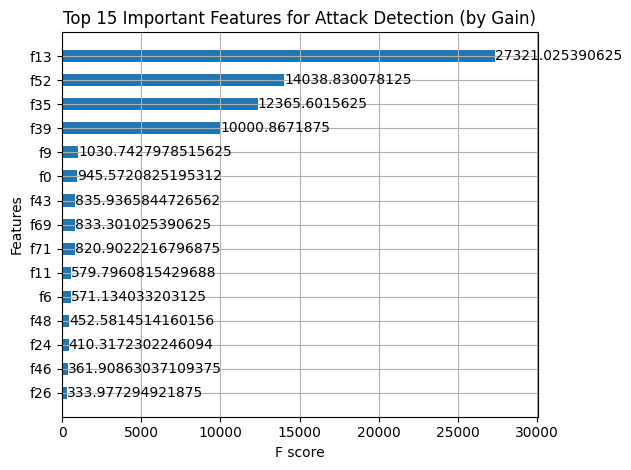

In [13]:
plt.figure(figsize=(12, 6))
plot_importance(xgb, max_num_features=15, height=0.5, importance_type='gain')
plt.title("Top 15 Important Features for Attack Detection (by Gain)")
plt.tight_layout()
plt.show()

**Evaluation**

In [14]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    681396
           1       1.00      1.00      1.00    166967

    accuracy                           1.00    848363
   macro avg       1.00      1.00      1.00    848363
weighted avg       1.00      1.00      1.00    848363



**Confusion matrix**

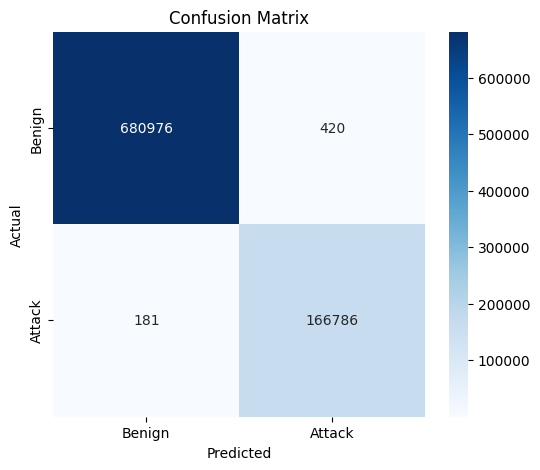

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**ROC Curve**

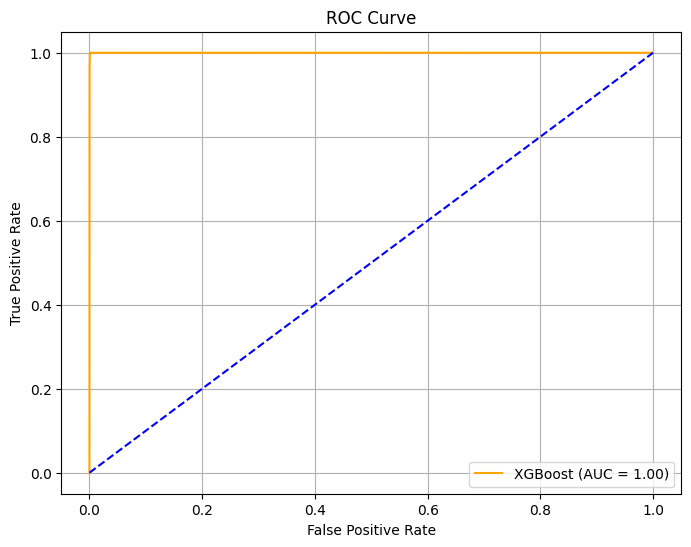

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Step 1: Start with your new partial data
partial_data = {
    'Destination Port': 54865,
    'Flow Duration': 3,
    'Total Fwd Packets': 2,
    'Total Backward Packets': 0,
    'Total Length of Fwd Packets': 12,
    'Total Length of Bwd Packets': 0,
    'Fwd Packet Length Max': 6,
    'Fwd Packet Length Min': 6,
    'Fwd Packet Length Mean': 6,
    'Fwd Packet Length Std': 0.0,
    # You can add more known values here...
}

# Step 2: Create full empty DataFrame row with all required feature columns
full_input = pd.DataFrame(columns=X.columns)
full_input.loc[0] = 0  # initialize all values to 0

# Step 3: Fill in known values
for col, value in partial_data.items():
    if col in full_input.columns:
        full_input.at[0, col] = value

# Step 4: Scale it using your existing scaler
full_input_scaled = scaler.transform(full_input)

# Step 5: Predict using your trained XGBoost model
prediction = xgb.predict(full_input_scaled)
proba = xgb.predict_proba(full_input_scaled)[0][1]

print("Prediction:", "Attack" if prediction[0] == 1 else "Benign")
print("Attack Probability:", proba)


Prediction: Benign
Attack Probability: 3.161548e-08


In [19]:
from sklearn.metrics import accuracy_score

# Accuracy on test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the XGBoost model: {accuracy * 100:.2f}%")


Accuracy of the XGBoost model: 99.93%


In [20]:
print(f"""
Model Evaluation:
------------------------
✅ Accuracy       : {accuracy_score(y_test, y_pred):.4f}
📈 ROC AUC        : {roc_auc:.4f}
📊 Confusion Matrix:
{confusion_matrix(y_test, y_pred)}
""")



Model Evaluation:
------------------------
✅ Accuracy       : 0.9993
📈 ROC AUC        : 1.0000
📊 Confusion Matrix:
[[680976    420]
 [   181 166786]]



In [21]:
import joblib

# Save model
joblib.dump(xgb, 'xgboost_cicids2017_model.pkl')

# Save the scaler too (important!)
joblib.dump(scaler, 'scaler_cicids2017.pkl')


['scaler_cicids2017.pkl']

In [22]:
from google.colab import files
files.download('xgboost_cicids2017_model.pkl')
files.download('scaler_cicids2017.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import joblib
import pandas as pd

# Load model and scaler
loaded_model = joblib.load('xgboost_cicids2017_model.pkl')
loaded_scaler = joblib.load('scaler_cicids2017.pkl')

# Your partial data (just the known features)
partial_data = {
    'Destination Port': 54865,
    'Flow Duration': 3,
    'Total Fwd Packets': 2,
    'Total Backward Packets': 0,
    'Total Length of Fwd Packets': 12,
    'Total Length of Bwd Packets': 0,
    'Fwd Packet Length Max': 6,
    'Fwd Packet Length Min': 6,
    'Fwd Packet Length Mean': 6,
    'Fwd Packet Length Std': 0.0,
    # Add more if you know
}

# Step 1: Create a full input row using the features model was trained on
full_input = pd.DataFrame(columns=loaded_model.feature_names_in_)
full_input.loc[0] = 0  # set all features to 0

# Step 2: Fill the known partial values into the full input
for col, val in partial_data.items():
    if col in full_input.columns:
        full_input.at[0, col] = val

# Step 3: Scale the input
scaled_data = loaded_scaler.transform(full_input)

# Step 4: Predict
prediction = loaded_model.predict(scaled_data)
proba = loaded_model.predict_proba(scaled_data)[0][1]

print("✅ Prediction:", "Attack" if prediction[0] == 1 else "Benign")
print("📈 Attack Probability:", round(proba * 100, 2), "%")



AttributeError: `feature_names_in_` is defined only when `X` has feature names that are all strings.